# Exercice crunching de data - Tic Tac Trip

Tic Tac Trip est un comparateur permettant de réserver des voyages à travers l'europe en combinant différents moyens de transport sur un même trajet.  
Le but de l'exercice est de :  
   -extraire des infos intéressantes type prix min,moyen et max, durée min/max/moyenne par trajet  
   -afficher les prix moyen et durée selon le train, le bus et le covoit selon la distance du trajet (0-200km, 201-800km, 800-2000km, 2000+km) 

### Imports:
On aura besoin de geopy pour le calcul de la distance à partir de latitude et de longitude

In [1]:
!pip install geopy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import timedelta
from geopy import distance

### Importation des données:
L'exercice propose 4 dataset sous format csv:  
-ticket_data.csv: Les données relatives au propositions de tickets  
-cities.csv: Les villes desservies par TicTacTrip  
-stations.csv: Les stations desservies par TicTacTrip  
-providers.csv: Les données relatives au différents providers  
On va commencer par importer les données et essayer de les comprendre en affichant les 5 premières lignes ainsi que les types des colonnes

In [3]:
ticket_data = pd.read_csv('./data/ticket_data.csv')

In [4]:
cities = pd.read_csv('./data/cities.csv')

In [5]:
stations = pd.read_csv('./data/stations.csv')

In [6]:
providers = pd.read_csv('./data/providers.csv')

In [7]:
print(ticket_data.columns.values)
ticket_data.head()

['id' 'company' 'o_station' 'd_station' 'departure_ts' 'arrival_ts'
 'price_in_cents' 'search_ts' 'middle_stations' 'other_companies' 'o_city'
 'd_city']


,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


In [8]:
ticket_data.dtypes

id                   int64
company              int64
o_station          float64
d_station          float64
departure_ts        object
arrival_ts          object
price_in_cents       int64
search_ts           object
middle_stations     object
other_companies     object
o_city               int64
d_city               int64
dtype: object

In [9]:
print(cities.columns.values)
cities.head()

['id' 'local_name' 'unique_name' 'latitude' 'longitude' 'population']


,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [10]:
cities.dtypes

id               int64
local_name      object
unique_name     object
latitude       float64
longitude      float64
population     float64
dtype: object

In [11]:
print(stations.columns.values)
stations.head()

['id' 'unique_name' 'latitude' 'longitude']


,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737


In [12]:
stations.dtypes

id               int64
unique_name     object
latitude       float64
longitude      float64
dtype: object

In [13]:
print(providers.columns.values)
providers.head()

['id' 'company_id' 'provider_id' 'name' 'fullname' 'has_wifi' 'has_plug'
 'has_adjustable_seats' 'has_bicycle' 'transport_type']


,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus


In [14]:
providers.dtypes

id                       int64
company_id               int64
provider_id             object
name                    object
fullname                object
has_wifi                object
has_plug                object
has_adjustable_seats    object
has_bicycle             object
transport_type          object
dtype: object

## Prix Min,Moyen,Max:

In [15]:
price_average = ticket_data["price_in_cents"].mean()
price_min = min(ticket_data["price_in_cents"])
price_max = max(ticket_data["price_in_cents"])
print("prix moyen des trajets:", price_average)
print("prix minimum des trajets:", price_min)
print("prix maximum des trajets:", price_max)

prix moyen des trajets: 4382.711061374178
prix minimum des trajets: 300
prix maximum des trajets: 38550


## Prix Min,Moyen,Max par trajet:
On considère ici qu'un trajet est caractérisé par une ville de départ et une ville d'arrivée

In [16]:
price_average_trip = ticket_data.groupby(["o_city","d_city"])["price_in_cents"].mean()
price_min_trip = ticket_data.groupby(["o_city","d_city"])["price_in_cents"].min()
price_max_trip = ticket_data.groupby(["o_city","d_city"])["price_in_cents"].max()
price_average_trip = pd.DataFrame(price_average_trip)
price_average_trip.rename(columns={"price_in_cents":"price_average"},inplace=True)
price_min_trip = pd.DataFrame(price_min_trip)
price_min_trip.rename(columns={"price_in_cents":"price_min"},inplace=True)
price_max_trip = pd.DataFrame(price_max_trip)
price_max_trip.rename(columns={"price_in_cents":"price_max"},inplace=True)
stats=price_min_trip.merge(price_max_trip,on = ["o_city","d_city"]).merge(price_average_trip,on = ["o_city","d_city"])
stats.head()

price_min  price_max  price_average
o_city d_city                                     
5      23          18600      22000   20320.000000
6      227          9860      13650   11755.000000
       504          2000       8920    4042.666667
       628          2600       3190    2797.500000
       845           700       2420     864.626866

## Durée Min,Moyenne,Max:
On va rajouter une colonne "duration" à ticket_data qui nous sera utile ultérieurement

In [17]:
departure = pd.to_datetime(ticket_data["departure_ts"])
arrival = pd.to_datetime(ticket_data["arrival_ts"])
ticket_data["duration"] =arrival-departure
duration_average = ticket_data['duration'].mean()
duration_min = min(ticket_data['duration'])
duration_max = max(ticket_data['duration'])
print("durée moyenne par trajet:", duration_average)
print("durée minimum par trajet:", duration_min)
print("durée maximum par trajet:", duration_max)

durée moyenne par trajet: 0 days 07:04:37.247600
durée minimum par trajet: 0 days 00:20:00
durée maximum par trajet: 20 days 12:51:00


## Durée Min,Moyenne,Max par trajet:

In [18]:
duration_average_trip = ticket_data.groupby(["o_city","d_city"])["duration"].apply(lambda x: np.mean(x))
duration_min_trip = ticket_data.groupby(["o_city","d_city"])["duration"].min()
duration_max_trip = ticket_data.groupby(["o_city","d_city"])["duration"].max()
duration_average_trip = pd.DataFrame(duration_average_trip)
duration_average_trip.rename(columns={"duration":"duration_average"},inplace=True)
duration_min_trip = pd.DataFrame(duration_min_trip)
duration_min_trip.rename(columns={"duration":"duration_min"},inplace=True)
duration_max_trip = pd.DataFrame(duration_max_trip )
duration_max_trip.rename(columns={"duration":"duration_max"},inplace=True)
stats=duration_min_trip.merge(duration_max_trip,on = ["o_city","d_city"]).merge(duration_average_trip,on = ["o_city","d_city"])
stats.head()

duration_min duration_max duration_average
o_city d_city                                           
5      23         08:53:00     15:54:00         10:18:48
6      227        12:24:00     15:01:00         13:42:30
       504        05:36:00     12:20:00         08:17:24
       628        09:40:00     14:30:00         12:10:00
       845        01:00:00     04:11:00  01:19:54.626865

## Prix moyen et durée moyenne selon le type de transport selon la distance

### Déterminer le type de transport:
En visitant le site TicTacTrip, on trouve que pour un même ticket on peut avoir 4 types de transport comme le montre l'image ci-dessous  
-Bus  
-Train  
-Combiné (Train+Bus)  
-Covoiturage  
<img src="./tictactrip1.png">  
On devrait donc trouver cela à travers notre dataset  
On va commencer par écrire une fonction qui à partir d'un id de provider retourne le type de transport

In [19]:
def mapproviders(id):
    return providers[providers["id"]==id]["transport_type"].values[0]

Puis on utilise cette fonction dans une seconde qui à partir de company et other_companies retourne une liste sans doublons des types de transports  
On commence par vérifier que other_companies n'a pas la valeur Nan
other_companies étant un string, on enlève les accolades au début et à la fin et on transforme ça en liste et on rajoute company à cette liste  
On utilise enfin mapproviders pour avoir la liste des types de transport. On enlève les doublons avec set

In [20]:
def transport(company,other_companies):
    companies=[]
    if(pd.isna(other_companies)):
        companies.append(company)
    else:
        companies=other_companies[1:-1]
        companies=companies.split(",")
        companies=[int(i) for i in companies]
        companies.append(company)
    result=[]
    for c in companies:
        result.append(mapproviders(c))
    result=set(result)
    result=",".join(list(result))
    return result

Il suffit maintenant d'appliquer la fonction transport sur les lignes de notre dataset ticket_data

In [21]:
ticket_data["transport_type"]=ticket_data.apply(lambda row: transport(row["company"],row["other_companies"]),axis=1)
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,transport_type
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,0 days 06:10:00,carpooling
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,0 days 17:50:00,bus
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,1 days 07:57:00,train
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,0 days 21:35:00,train
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,0 days 21:46:00,train


In [22]:
ticket_data["transport_type"].value_counts()

carpooling    41441
train         18815
bus           13629
train,bus       283
Name: transport_type, dtype: int64

#### Ces valeurs corresspondent à notre hypothèse

In [23]:
ticket_data["transport_type"]=ticket_data["transport_type"].str.replace('train,bus', 'combiné')
ticket_data["transport_type"].value_counts()

carpooling    41441
train         18815
bus           13629
combiné         283
Name: transport_type, dtype: int64

### Déterminer la distance parcourue:
Pour calculer la distance on va devoir émettre quelques hypothèses.
Pour le calcul de distances pour le covoiturage on devra utiliser la distance entre les villes d'origine et d'arrivée.
Pour les stations on remarque que les stations sont toujours en nombre pairs 
En faisant un tour sur le site de TicTacTrip on trouve:  
Soit des escales où les 2 stations sont identiques avec ou sans changement de type de transport comme le montre l'image ci-dessous:
<img src="./tictactrip2.png"> 
Dans cet exemple la distance se calcule: Paris Bercy Seine Bus Station -> Lille + Lille -> Berlin Airport BER  
Soit des escale où la personne devra changer de station (à pieds,en taxi etc)comme le montre l'images ci-dessous:
<img src="./tictactrip3.png">  
La distance ici se calcule: Paris Bercy Seine Bus Station -> Lille tourcoing + Lille -> Berlin Airport BER   
La distance entre les deux stations intermédiaires (ici Lille tourcoing -> Lille) ne devra donc pas être compter vu que le client fera ça lui même

Prenons maintenant un exemple de la dataset. Si nous avons:  
o_station=5905
d_station=6495
Middle_stations={798,798,6794,6246}  
Il suffit de calculer 5905->798+798->6794+6246->6495  
On peut donc à partir d'une liste de stations calculer la distance totale du trajet en sommant les distances entre les couples de stations consécutifs  
Les fonctions mapstations et mapcities permettent à partir d'un id de retourner la latitude et la longitude de la station ou ville

In [24]:
def mapstations(id):
    return stations[stations["id"]==id][["latitude","longitude"]].values

In [25]:
def mapcities(id):
    return cities[cities["id"]==id][["latitude","longitude"]].values

In [26]:
def calculdistance(o_station,d_station,middle_station,o_city,d_city):
    if(pd.isna(o_station)):
        origin=mapcities(o_city)
        destination=mapcities(d_city)
        value=distance.distance((origin[0][0],origin[0][1]),(destination[0][0],destination[0][1]))
    else:    
        value=0
        middle_station=middle_station[1:-1]
        liste=middle_station.split(",")
        liste = [int(i) for i in liste]
        liste.append(d_station)
        liste.insert(0,o_station)
        for i in range(0,len(liste),2):
            station1=mapstations(liste[i])
            station2=mapstations(liste[i+1])
            value+=distance.distance((station1[0][0],station1[0][1]),(station2[0][0],station2[0][1])).km
    return value

In [27]:
def distancecategory(distance):
    if(distance>2000):
        return "2000+km"
    elif(distance>800):
        return "800-2000km"
    elif(distance>201):
        return "201-800km"
    else:
        return "0-200km"

In [28]:
ticket_data["distance"]=ticket_data.apply(lambda row: calculdistance(row["o_station"],row["d_station"],row["middle_stations"],row["o_city"],row["d_city"]),axis=1)
ticket_data["category"]=ticket_data.apply(lambda row: distancecategory(row["distance"]),axis=1)

In [29]:
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,transport_type,distance,category
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,0 days 06:10:00,carpooling,503.1368310487561 km,201-800km
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,0 days 17:50:00,bus,505.99,201-800km
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,1 days 07:57:00,train,1054.48,800-2000km
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,0 days 21:35:00,train,1054.48,800-2000km
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,0 days 21:46:00,train,630.203,201-800km


### Prix Moyen et durée moyenne selon la distance et le type de transport
On va maintenant laisser les colonnes qui nous intéressent et grouper les résultat selon le type de transport et la category de distance

In [30]:
result=ticket_data[["transport_type","category","duration","price_in_cents"]]
result["duration_seconds"]=result["duration"].apply(lambda x:timedelta.total_seconds(x))
result.head()

<ipython-input-30-7b1cba2dce07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["duration_seconds"]=result["duration"].apply(lambda x:timedelta.total_seconds(x))


,transport_type,category,duration,price_in_cents,duration_seconds
0,carpooling,201-800km,0 days 06:10:00,4550,22200.0
1,bus,201-800km,0 days 17:50:00,1450,64200.0
2,train,800-2000km,1 days 07:57:00,7400,115020.0
3,train,800-2000km,0 days 21:35:00,13500,77700.0
4,train,201-800km,0 days 21:46:00,7710,78360.0


In [31]:
prix_moyen=pd.DataFrame(result.groupby(["transport_type","category"])["price_in_cents"].mean())
prix_moyen

price_in_cents
transport_type category                  
bus            0-200km        1902.847273
               201-800km      3352.311854
               800-2000km     6838.667455
carpooling     0-200km        1194.539117
               201-800km      3231.112367
               800-2000km     8626.545455
combiné        0-200km        2992.048193
               201-800km      7610.450000
train          0-200km        2872.669882
               201-800km      8942.004444
               800-2000km    16509.400510

In [32]:
durée_moyenne=pd.DataFrame(ticket_data.groupby(["transport_type","category"])["duration"].apply(lambda x: np.mean(x)))
durée_moyenne

duration
transport_type category                         
bus            0-200km    0 days 07:34:39.600000
               201-800km  0 days 14:52:03.891617
               800-2000km 1 days 03:13:17.919621
carpooling     0-200km    0 days 01:58:37.389620
               201-800km  0 days 04:46:50.371327
               800-2000km 0 days 13:06:00.839160
combiné        0-200km    0 days 04:45:20.240963
               201-800km         0 days 10:41:27
train          0-200km    0 days 04:14:47.926348
               201-800km  0 days 07:29:38.689523
               800-2000km 0 days 12:44:19.821428

## Interprétation et visualisation des résultats:
On va commencer par donner des histogrammes des prix moyens et des durées moyennes en fonction de la distance et du type de transport

Text(37.58247395833334, 0.5, 'Prix moyens (cents)')

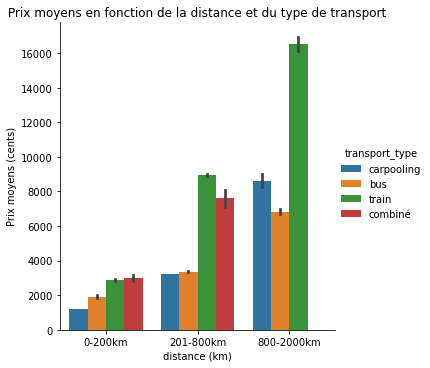

In [33]:
hist=sns.catplot(x="category",y="price_in_cents",hue="transport_type",kind="bar",data=ticket_data,order=["0-200km","201-800km","800-2000km"])
plt.title("Prix moyens en fonction de la distance et du type de transport")
plt.xlabel("distance (km)")
plt.ylabel("Prix moyens (cents)")

Text(39.14966145833334, 0.5, 'Durée (sec)')

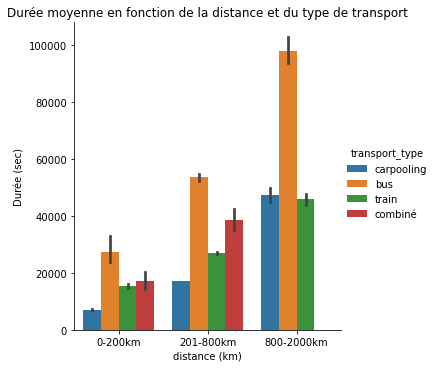

In [34]:
hist=sns.catplot(x="category",y="duration_seconds",hue="transport_type",kind="bar",data=result,order=["0-200km","201-800km","800-2000km"])
plt.title("Durée moyenne en fonction de la distance et du type de transport")
plt.xlabel("distance (km)")
plt.ylabel("Durée (sec)")

On remarque que le prix est proportionel à la distance  
Le train est le plus cher que le bus mais est bien plus rapide aussi  
Le covoiturage est rentable pour les petits et moyens trajets et reste efficace pour les longues distance en terme de rapport Durée/Prix  

Nous allons maintenant essayer de trouver ce que l'on peut faire à partir de nos différentes datasets

In [35]:
ticket_data["DepartureDay"]=departure.apply(lambda x: x.weekday())
ticket_data["ArrivalDay"]=arrival.apply(lambda x: x.weekday())
res=ticket_data.groupby(["DepartureDay"])["id"].count().reset_index()
res

,DepartureDay,id
0,0,6310
1,1,2974
2,2,4749
3,3,5297
4,4,34466
5,5,10581
6,6,9791


Text(-9.075000000000003, 0.5, 'Nombre')

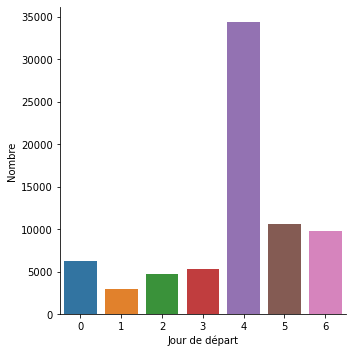

In [36]:
hist=sns.catplot(x="DepartureDay",y="id",kind="bar",data=res)
plt.xlabel("Jour de départ")
plt.ylabel("Nombre")

On remarque que la plupart des départs se font le vendredi

In [37]:
res1=ticket_data.groupby(["ArrivalDay"])["id"].count().reset_index()
res1

,ArrivalDay,id
0,0,6963
1,1,3225
2,2,4838
3,3,4844
4,4,30138
5,5,14071
6,6,10089


Text(-9.075000000000003, 0.5, 'Nombre')

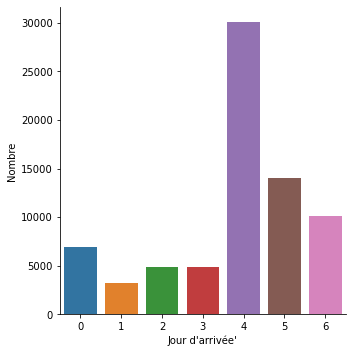

In [38]:
hist=sns.catplot(x="ArrivalDay",y="id",kind="bar",data=res1)
plt.xlabel("Jour d'arrivée'")
plt.ylabel("Nombre")

On remarque le la plupart des arrivées se font aussi le vendredi

In [39]:
res2=ticket_data.groupby(["transport_type"])["id"].count().reset_index()
res2

,transport_type,id
0,bus,13629
1,carpooling,41441
2,combiné,283
3,train,18815


Text(-9.075000000000003, 0.5, 'Nombre')

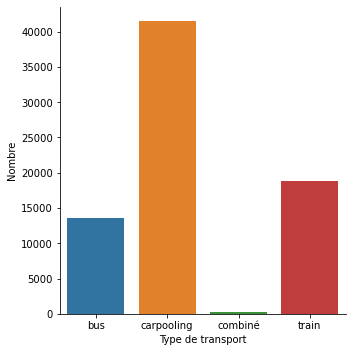

In [40]:
hist=sns.catplot(x="transport_type",y="id",kind="bar",data=res2)
plt.xlabel("Type de transport")
plt.ylabel("Nombre")

Le covoiturage est donc le moyen de transport le plus utilisé. La combinaison train bus est peu utilisée

## Conclusion:  
Les datasets proposées sont très intéressantes. On peut on extraire d'avantage d'interprétations tel que la relation entre le prix et la data de recherche du ticket ainsi que le prix et la présence de sièges ajustable de wifi ou de prises.
On peut aussi à partir des datasets implémenter un modèle supervisé de prédiction des prix. Ceci peut s'avèrer particulièrement interessante pour pouvoir prédir quand faire la recherche pour avoir le meilleur prix. 
### Conclusion personnelle:
Cet exercice fut vraiment fun à faire. Ca change vraiment des tests techniques que je vois en cette période et je vous en remercie. Cela m'a permit aussi de faire plus de recherches sur l'entreprise pour comprendre l'ambiguité des données.